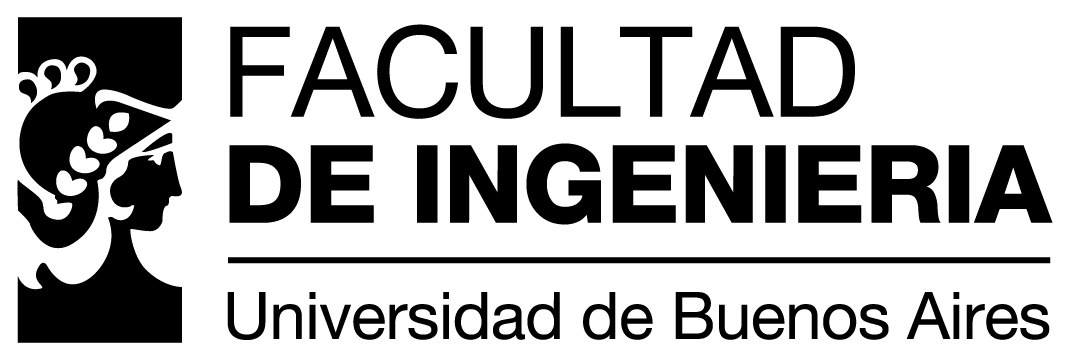

# Trabajo Practico: Sistema Oscilatorio Amortiguado

### **Integrantes**

| **Alumno**       | **Padrón** | **E-mail**          |
|-------------------|-----------|---------------------|
| Máximo Utrera     | 109651    | mutrera@fi.uba.ar   |
| Máximo Utrera     | 109651    | mutrera@fi.uba.ar   |
| Máximo Utrera     | 109651    | mutrera@fi.uba.ar   |


*Modelacion Numerica - 2° Cuatrimestre 2024*


## Imports

In [48]:
import numpy as np
import matplotlib.pyplot as plt
import time
from tabulate import tabulate

# Primera parte

## Ponderado implicito

In [49]:
# Parámetros iniciales
m = 109651 / 200
k = 25000
c_0 = 0.1
c_velocity = 0
t_final = 5

def ponderado_implicito(beta, dt, t_max, k, m, lmbda=0, c=0, c_velocity=0, u_0=0, v_0=0, **kwargs):
    t = np.arange(0, t_max + dt, dt, dtype=np.float64)
    u = np.zeros_like(t, dtype=np.float64)
    v = np.zeros_like(t, dtype=np.float64)

    u[0] = u_0
    v[0] = v_0

    for n in range(len(t) - 1):
        # Estimaciones iniciales
        u_next = u[n]
        v_next = v[n]

        # Iteración para resolver sistema implícito (20 iters o err < max_err)
        for _ in range(20):
            u_next_new = u[n] + dt * ((1 - beta) * f(v[n]) + beta * f(v_next))
            v_next_new = v[n] + dt * ((1 - beta) * g(u[n], v[n], k, m, c, c_velocity, lmbda) + beta * g(u_next, v_next, k, m, c, c_velocity, lmbda))

            # Verificar convergencia
            if np.abs(u_next_new - u_next, dtype=np.float64) < kwargs.get("max_err", 1e-6) and np.abs(v_next_new - v_next, dtype=np.float64) < kwargs.get("max_err", 1e-6):
                break

            u_next = u_next_new
            v_next = v_next_new

        u[n + 1] = u_next
        v[n + 1] = v_next

    return t, u, v

def f(v):
  return v

def g(u, v, k, m, c, c_velocity, lmbda):
    return (k / m) * (c - u) + (lmbda / m) * (c_velocity - v)

## Frecuencia natural

In [50]:
omega_n = np.sqrt(k / m)
print(f"Frecuencia natural analítica: {omega_n:.4f} rad/s")

def estimar_frecuencia(t, u):
    """Estima la frecuencia natural a partir del período de oscilación."""
    indices_max = (np.diff(np.sign(np.diff(u))) < 0).nonzero()[0] + 1
    if len(indices_max) > 1:
        periodos = np.diff(t[indices_max])
        frecuencia_exp = 1 / np.mean(periodos)
        return frecuencia_exp
    else:
        return None

beta = 0.5
t, u, v = ponderado_implicito(beta, 0.005, t_final, k, m, c=c_0)
frecuencia_exp = estimar_frecuencia(t, u)
if frecuencia_exp:
    print(f"Frecuencia natural experimental: {2 * np.pi * frecuencia_exp:.4f} rad/s")
else:
    print("No se pudo estimar la frecuencia experimental.")

Frecuencia natural analítica: 6.7527 rad/s
Frecuencia natural experimental: 6.7561 rad/s


## Comparacion inicial

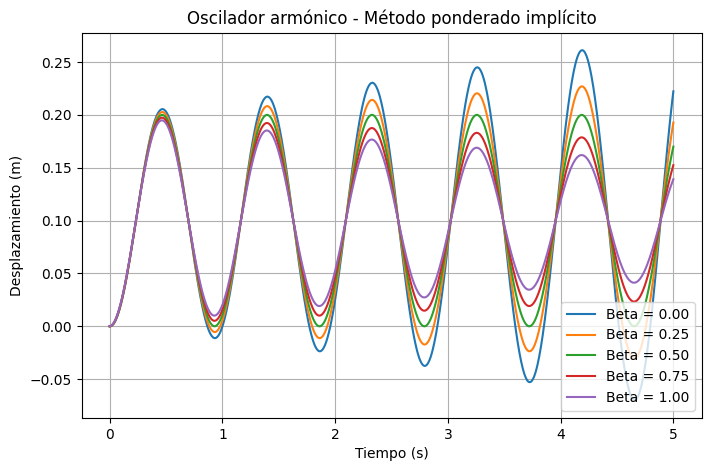

In [51]:
dt = 0.005
betas = np.arange(0, 1.25, 0.25)

plt.figure(figsize=(8, 5))

for beta in betas:
    t, u, v = ponderado_implicito(beta, dt, t_final, k, m, c=c_0)
    plt.plot(t, u, label=f"Beta = {beta:.2f}")

plt.title("Oscilador armónico - Método ponderado implícito")
plt.xlabel("Tiempo (s)")
plt.ylabel("Desplazamiento (m)")
plt.legend()
plt.grid()
plt.show()

## Analisis de estabilidad variando β y Δt

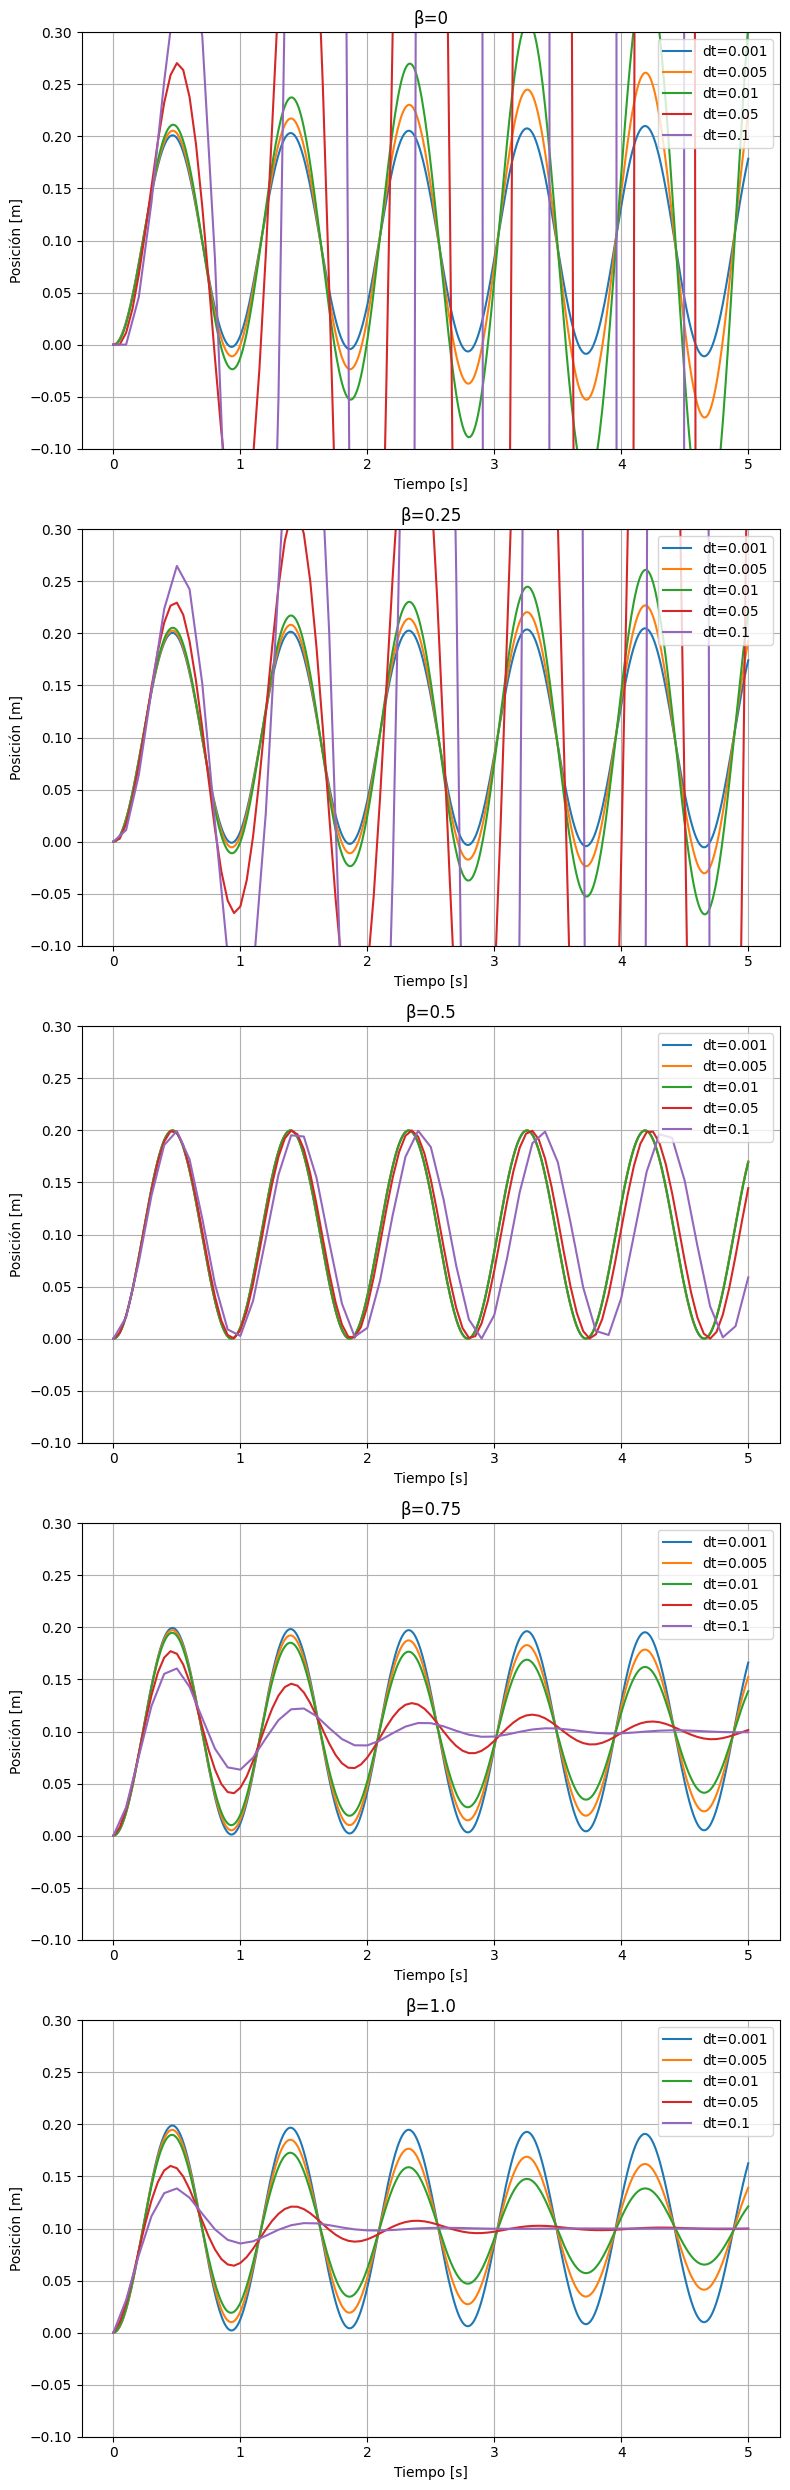

In [52]:
def analizar_estabilidad():
    dt_values = [0.001, 0.005, 0.01, 0.05, 0.1]
    betas = [0, 0.25, 0.5, 0.75, 1.0]

    # subplot para cada beta
    fig, axs = plt.subplots(len(betas), 1, figsize=(8, 5*len(betas)))

    for i, beta in enumerate(betas):
        for dt in dt_values:
            t, u, v = ponderado_implicito(beta, dt, t_final, k, m, c=c_0)
            axs[i].plot(t, u, label=f'dt={dt}')

        axs[i].grid(True)
        axs[i].set_xlabel('Tiempo [s]')
        axs[i].set_ylabel('Posición [m]')
        axs[i].set_title(f'β={beta}')
        axs[i].set_ylim(-0.1, 0.3)
        axs[i].legend()

    plt.tight_layout()
    plt.show()

analizar_estabilidad()

## Δt Optimo

## Analisis del error

In [53]:
def sol_analitica_parte_1(t, c, omega_n):
    return c * (1 - np.cos(omega_n * t))

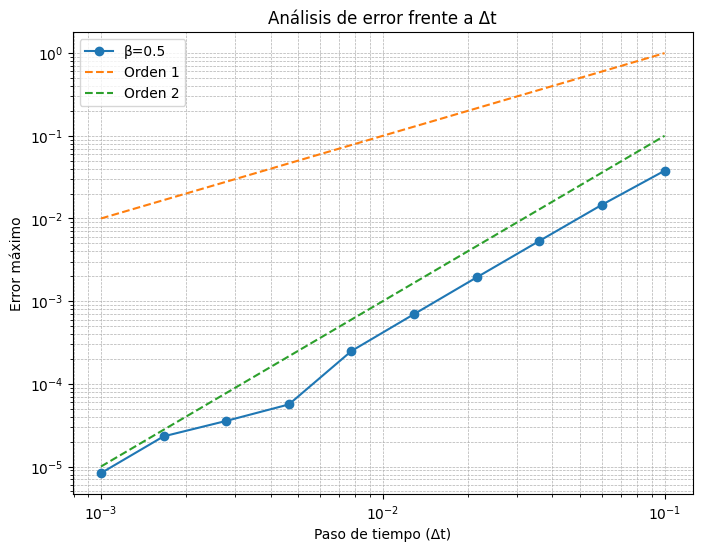

In [54]:
def calculate_error(u_numerica, t, omega_n):
    u_exacta = sol_analitica_parte_1(t, c_0, omega_n)
    return np.mean(np.abs(u_numerica - u_exacta))

def analizar_error():
    dt_values = np.logspace(-3, -1, 10)
    beta = 0.5
    errors = []

    for dt in dt_values:
        t, y, v = ponderado_implicito(beta, dt, t_final, k, m, c=c_0)
        error = calculate_error(y, t, omega_n)
        errors.append(error)

    # Gráficar error frente a dt
    plt.figure(figsize=(8, 6))
    plt.loglog(dt_values, errors, 'o-', label=f'β={beta}')
    plt.loglog(dt_values, dt_values * 10, '--', label='Orden 1')
    plt.loglog(dt_values, dt_values**2 * 10, '--', label='Orden 2')
    plt.grid(True, which='both', linestyle='--', linewidth=0.5)
    plt.xlabel('Paso de tiempo (Δt)')
    plt.ylabel('Error máximo')
    plt.title('Análisis de error frente a Δt')
    plt.legend()
    plt.show()

analizar_error()

**Comparacion de B = 0.5 y dt = 0.001 con analitica**

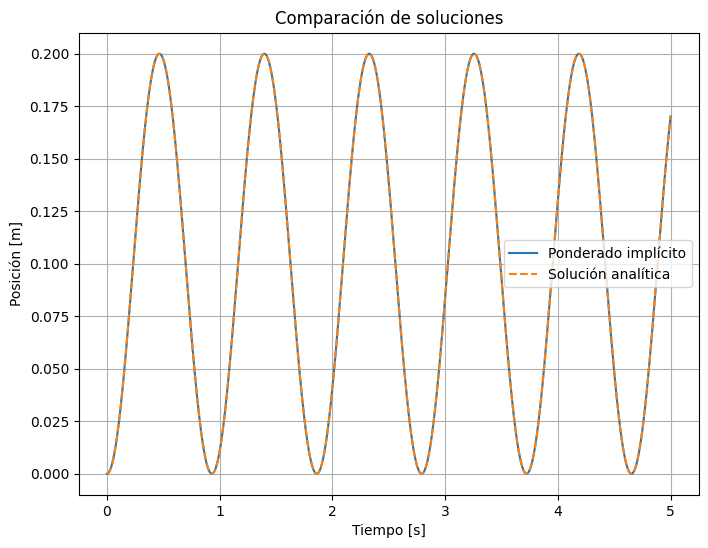

In [55]:
t, y, v = ponderado_implicito(0.5, 0.001, t_final, k, m, c=c_0)
y_exact = sol_analitica_parte_1(t, c_0, omega_n)

plt.figure(figsize=(8, 6))
plt.plot(t, y, label='Ponderado implícito')
plt.plot(t, y_exact, label='Solución analítica', linestyle='--')
plt.grid(True)
plt.xlabel('Tiempo [s]')
plt.ylabel('Posición [m]')
plt.title('Comparación de soluciones')
plt.legend()
plt.show()


Órdenes de convergencia:
β=0: 1.06
β=0.25: 1.03
β=0.5: 1.07
β=0.75: 0.98
β=1.0: 0.95


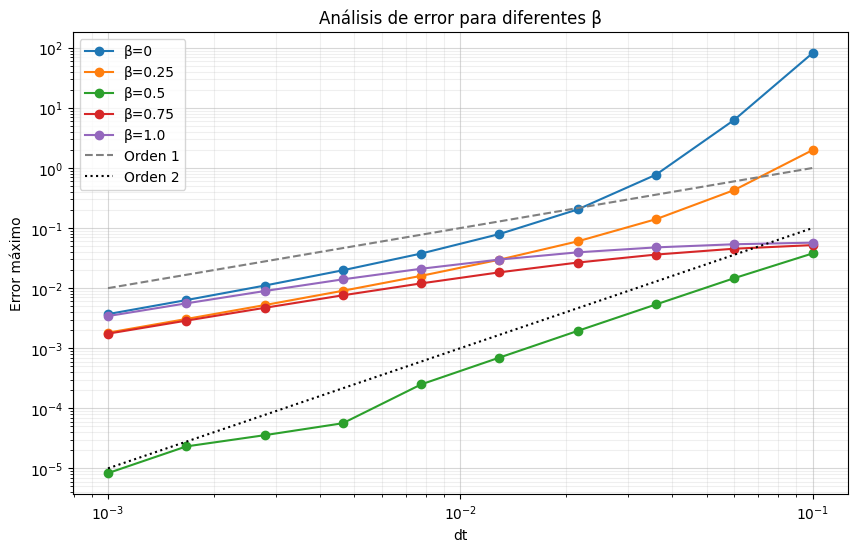

In [56]:
def analizar_error_multiple():
    dt_values = np.logspace(-3, -1, 10)
    betas = [0, 0.25, 0.5, 0.75, 1.0]

    plt.figure(figsize=(10, 6))

    print("\nÓrdenes de convergencia:")

    for beta in betas:
        errors = []
        for dt in dt_values:
            t, u, v = ponderado_implicito(beta, dt, t_final, k, m, c=c_0)
            error = calculate_error(u, t, omega_n)
            errors.append(error)

        # Calcular orden de convergencia ln(err_last/err_second_to_last) / ln(err_second_to_last/err_third_to_last)
        ln_errors = np.log(errors)
        orden = (ln_errors[3] - ln_errors[2]) / (ln_errors[2] - ln_errors[1])
        print(f"β={beta}: {orden:.2f}")

        # Graficar en escala logarítmica para cada beta
        plt.loglog(dt_values, errors, 'o-', label=f'β={beta}')

    # Agregar línea de referencia para orden 1 y 2
    ref_1 = dt_values * 10
    ref_2 = dt_values**2 * 10

    plt.loglog(dt_values, ref_1, '--', label='Orden 1', color='gray')
    plt.loglog(dt_values, ref_2, ':', label='Orden 2', color='black')

    plt.grid(True)
    plt.xlabel('dt')
    plt.ylabel('Error máximo')
    plt.title('Análisis de error para diferentes β')
    plt.legend()

    # Agregar cuadrícula para mejor lectura
    plt.grid(True, which="minor", ls="-", alpha=0.2)
    plt.grid(True, which="major", ls="-", alpha=0.5)

    plt.show()

analizar_error_multiple()

## Tiempos de calculo

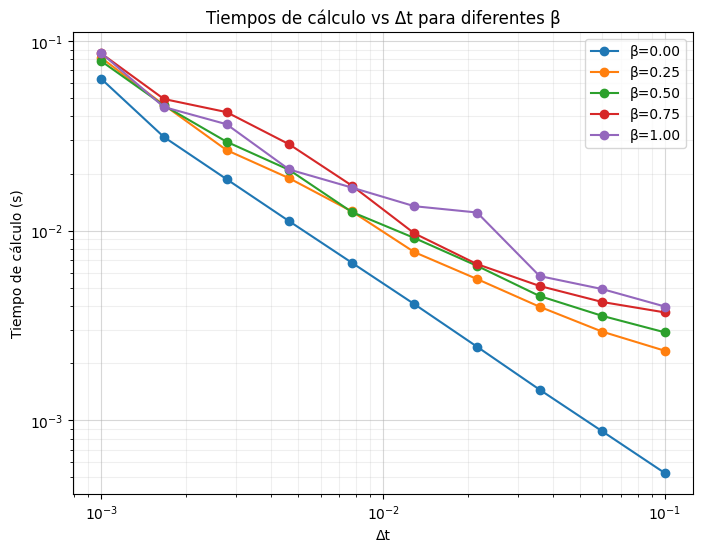


Tiempos de cálculo (segundos):
+--------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+
| Beta   |   dt=1.0e-03 |   dt=1.7e-03 |   dt=2.8e-03 |   dt=4.6e-03 |   dt=7.7e-03 |   dt=1.3e-02 |   dt=2.2e-02 |   dt=3.6e-02 |   dt=6.0e-02 |   dt=1.0e-01 |
+========+==============+==============+==============+==============+==============+==============+==============+==============+==============+==============+
| β=0.00 |       0.0632 |       0.0312 |       0.0187 |       0.0112 |       0.0068 |       0.0041 |       0.0024 |       0.0014 |       0.0009 |       0.0005 |
+--------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+
| β=0.25 |       0.0815 |       0.046  |       0.0266 |       0.0189 |       0.0126 |       0.0077 |       0.0056 |       0.004  |       0.0029 |       0.0023 |
+-

In [57]:
def medir_tiempos_calculo():
    betas = np.arange(0, 1.25, 0.25)
    dt_values = np.logspace(-3, -1, 10)

    tiempos = np.zeros((len(betas), len(dt_values)))

    for i, beta in enumerate(betas):
        for j, dt in enumerate(dt_values):
            inicio = time.perf_counter()
            _, _, _ = ponderado_implicito(beta, dt, t_final, k, m, c=c_0)
            fin = time.perf_counter()

            tiempos[i, j] = fin - inicio

    plt.figure(figsize=(8, 6))

    # Gráfico de tiempos
    for i, beta in enumerate(betas):
        plt.loglog(dt_values, tiempos[i], 'o-', label=f'β={beta:.2f}')

    plt.grid(True)
    plt.xlabel('Δt')
    plt.ylabel('Tiempo de cálculo (s)')
    plt.title('Tiempos de cálculo vs Δt para diferentes β')
    plt.legend()

    # Agregar cuadrícula
    plt.grid(True, which="minor", ls="-", alpha=0.2)
    plt.grid(True, which="major", ls="-", alpha=0.5)
    plt.show()

    # Resultados
    print("\nTiempos de cálculo (segundos):")
    headers = [f"dt={dt:.1e}" for dt in dt_values]
    table_data = []

    for i, beta in enumerate(betas):
        row = [f"β={beta:.2f}"] + [f"{t:.4f}" for t in tiempos[i]]
        table_data.append(row)

    print(tabulate(table_data, headers=["Beta"] + headers, tablefmt="grid"))

    # Stats
    print("\nEstadísticas:")
    print(f"Tiempo total de cálculo: {np.sum(tiempos):.4f} segundos")
    print(f"Tiempo promedio por simulación: {np.mean(tiempos):.4f} segundos")
    print(f"Tiempo máximo: {np.max(tiempos):.4f} segundos (β={betas[np.unravel_index(np.argmax(tiempos), tiempos.shape)[0]]:.2f}, dt={dt_values[np.unravel_index(np.argmax(tiempos), tiempos.shape)[1]]:.1e})")
    print(f"Tiempo mínimo: {np.min(tiempos):.4f} segundos (β={betas[np.unravel_index(np.argmin(tiempos), tiempos.shape)[0]]:.2f}, dt={dt_values[np.unravel_index(np.argmin(tiempos), tiempos.shape)[1]]:.1e})")

medir_tiempos_calculo()

**Obs:** a medida que el metodo se asemeja mas a su forma explicita pura disminuye su tiempo de ejecucion, es decir 0 < 0.25 < 0.5 < 0.75 < 1 (tiempo para cada β)

# 2da parte

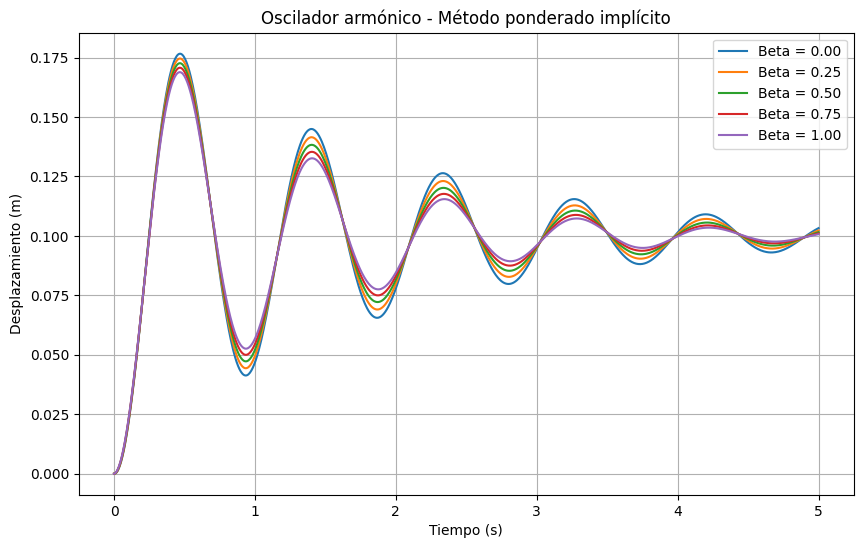

In [58]:
dt = 0.005
betas = np.arange(0, 1.25, 0.25)
lmbda_1 = 750

# Simulación para distintos valores de beta
plt.figure(figsize=(10, 6))
for beta in betas:
    t, u, v = ponderado_implicito(beta, dt, t_final, k, m, c=c_0, lmbda=lmbda_1)
    plt.plot(t, u, label=f"Beta = {beta:.2f}")

plt.title("Oscilador armónico - Método ponderado implícito")
plt.xlabel("Tiempo (s)")
plt.ylabel("Desplazamiento (m)")
plt.legend()
plt.grid()
plt.show()

# Solucion Vieja

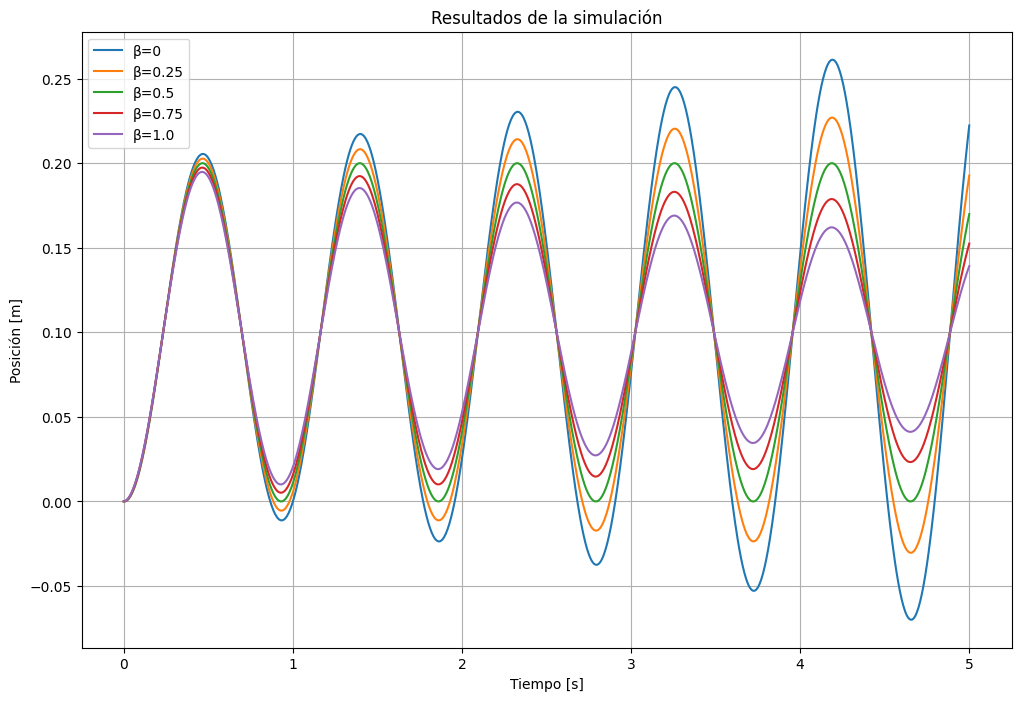

Frecuencia natural: 6.75 rad/s
Período natural: 0.93 s


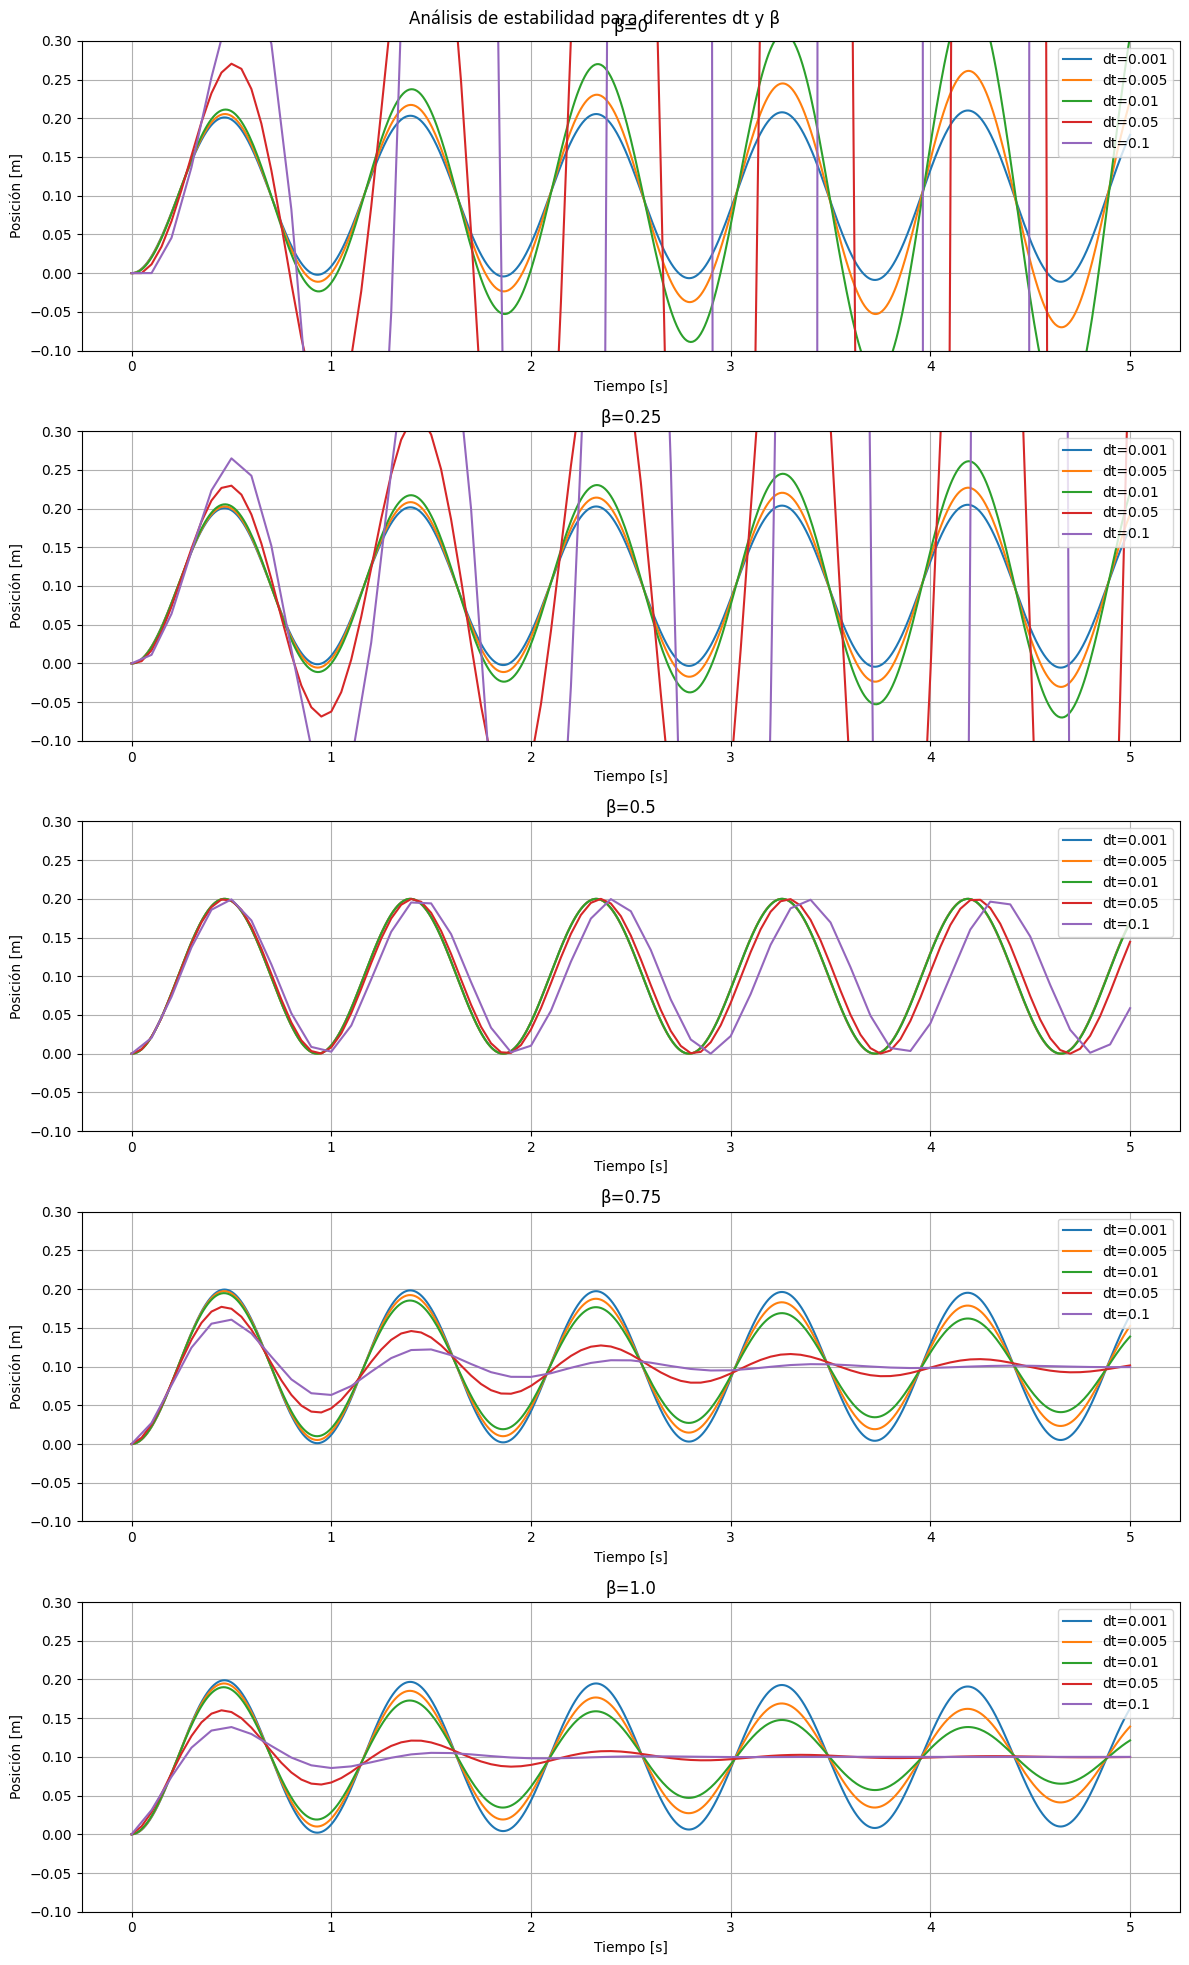

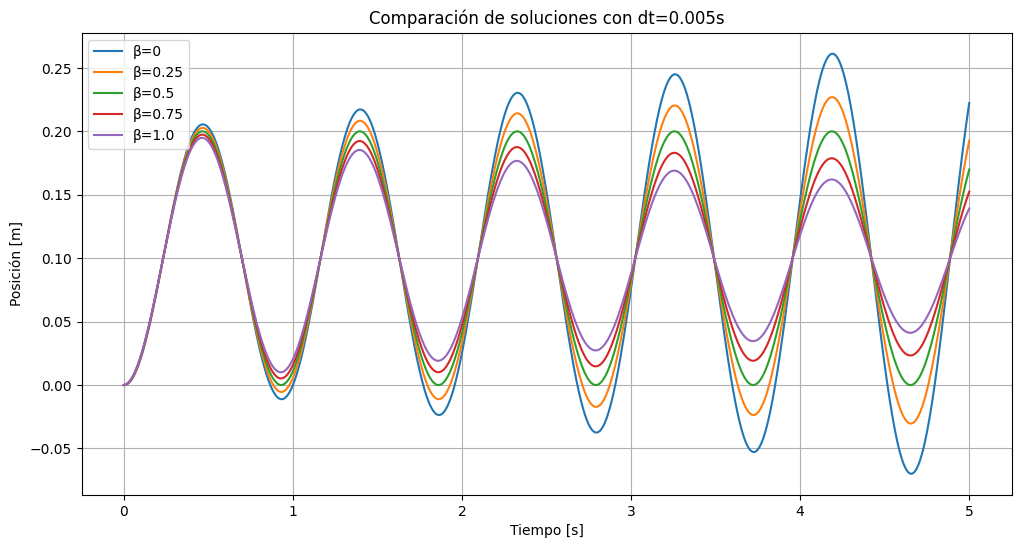

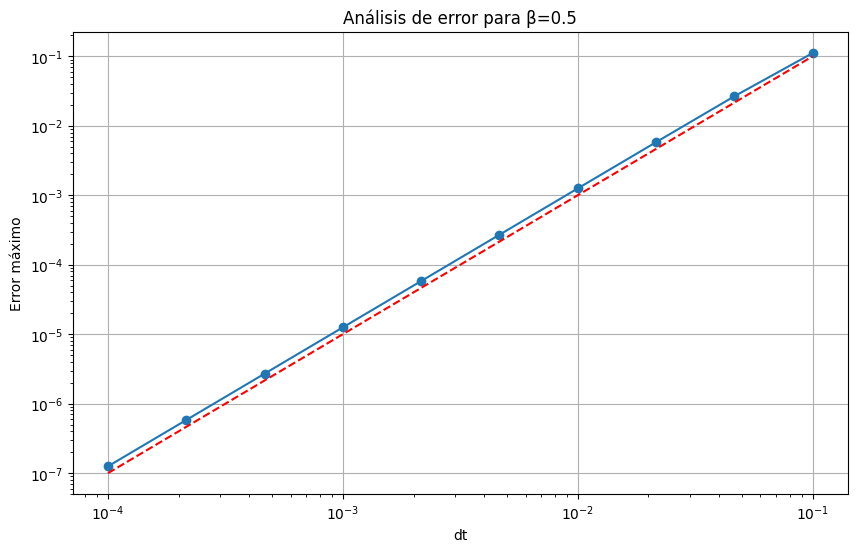

In [59]:
import numpy as np
import matplotlib.pyplot as plt

def solve_weighted_implicit(beta, dt, t_final, m, k, y0=0, v0=0):
    """
    Resuelve el oscilador armónico usando el método ponderado implícito

    Parámetros:
        beta: factor de ponderación
        dt: paso de tiempo
        t_final: tiempo final de simulación
        m: masa
        k: constante elástica
        y0: posición inicial
        v0: velocidad inicial

    Retorna:
        t: array de tiempos
        y: array de posiciones
        v: array de velocidades
    """
    # Crear array de tiempo
    t = np.arange(0, t_final + dt, dt)
    n = len(t)

    # Inicializar arrays de solución
    y = np.zeros(n)
    v = np.zeros(n)

    # Condiciones iniciales
    y[0] = y0
    v[0] = v0

    # Constante del sistema
    k_m = k/m

    # Matriz para la parte implícita
    A = np.array([[1, -beta*dt],
                  [beta*dt*k_m, 1]])

    c = 0.1  # elevación del terreno constante

    for i in range(n-1):
        # Parte explícita
        f1 = v[i]
        f2 = k_m*(c - y[i])

        # Vector lado derecho
        b = np.array([
            y[i] + dt*(1-beta)*f1,
            v[i] + dt*(1-beta)*f2 + beta*dt*k_m*c
        ])

        # Resolver sistema
        sol = np.linalg.solve(A, b)

        y[i+1] = sol[0]
        v[i+1] = sol[1]

    return t, y, v

def natural_frequency(k, m):
    """Calcula la frecuencia natural del sistema"""
    return np.sqrt(k/m)

def plot_solutions(results, title="Resultados de la simulación"):
    """
    Grafica los resultados para diferentes betas

    Parámetros:
        results: lista de tuplas (t, y, v, beta)
        title: título del gráfico
    """
    plt.figure(figsize=(12, 8))
    for t, y, v, beta in results:
        plt.plot(t, y, label=f'β={beta}')

    plt.grid(True)
    plt.xlabel('Tiempo [s]')
    plt.ylabel('Posición [m]')
    plt.title(title)
    plt.legend()
    plt.show()

def calculate_error(y_numerical, t, omega_n):
    """Calcula el error respecto a la solución analítica"""
    y_analytical = 0.1 * (1 - np.cos(omega_n * t))
    return np.max(np.abs(y_numerical - y_analytical))

# Parámetros del problema
padron = 109651  # REEMPLAZAR CON TU NÚMERO DE PADRÓN
m = padron/200  # masa [kg]
k = 25000       # constante elástica [N/m]
t_final = 5.0   # tiempo final [s]
dt = 0.005      # paso de tiempo [s]

# Resolver para diferentes valores de beta
betas = [0, 0.25, 0.5, 0.75, 1.0]
results = []

for beta in betas:
    t, y, v = solve_weighted_implicit(beta, dt, t_final, m, k)
    results.append((t, y, v, beta))

# Graficar resultados
plot_solutions(results)

# ------------------------------------------- Frecuencia natural -------------------------------------------

# Calcular y mostrar frecuencia natural
omega_n = natural_frequency(k, m)
print(f"Frecuencia natural: {omega_n:.2f} rad/s")
print(f"Período natural: {2*np.pi/omega_n:.2f} s")

# ------------------------------------------- Analisis de estabilidad -------------------------------------------

# Análisis de estabilidad para diferentes dt y diferentes beta
def analizar_estabilidad():
    dt_values = [0.001, 0.005, 0.01, 0.05, 0.1]
    betas = [0, 0.25, 0.5, 0.75, 1.0]

    # Crear subplots para cada beta con la misma escala
    fig, axs = plt.subplots(len(betas), 1, figsize=(12, 4*len(betas)))
    fig.suptitle('Análisis de estabilidad para diferentes dt y β')

    # Definir límites consistentes para todos los gráficos
    y_min, y_max = -0.1, 0.3

    for i, beta in enumerate(betas):
        for dt in dt_values:
            t, y, v = solve_weighted_implicit(beta, dt, t_final, m, k)
            axs[i].plot(t, y, label=f'dt={dt}')

        axs[i].grid(True)
        axs[i].set_xlabel('Tiempo [s]')
        axs[i].set_ylabel('Posición [m]')
        axs[i].set_title(f'β={beta}')
        axs[i].set_ylim(y_min, y_max)  # Establecer los mismos límites para todos
        axs[i].legend()

    plt.tight_layout()
    plt.show()

analizar_estabilidad()

# ------------------------------------------- Dt optimo -------------------------------------------

def comparar_soluciones_dt_optimo():
    dt = 0.005  # dt elegido
    betas = [0, 0.25, 0.5, 0.75, 1.0]
    results = []

    # Calcular solución para cada beta con el dt elegido
    for beta in betas:
        t, y, v = solve_weighted_implicit(beta, dt, t_final, m, k)
        results.append((t, y, v, beta))

    # Graficar resultados
    plt.figure(figsize=(12, 6))
    for t, y, v, beta in results:
        plt.plot(t, y, label=f'β={beta}')

    plt.grid(True)
    plt.xlabel('Tiempo [s]')
    plt.ylabel('Posición [m]')
    plt.title(f'Comparación de soluciones con dt={dt}s')
    plt.legend()
    plt.show()

comparar_soluciones_dt_optimo()

# ------------------------------------------- Analisis de error -------------------------------------------

# Análisis de error
def analizar_error():
    dt_values = np.logspace(-4, -1, 10)
    beta = 0.5  # probamos con método de segundo orden
    errors = []

    for dt in dt_values:
        t, y, v = solve_weighted_implicit(beta, dt, t_final, m, k)
        error = calculate_error(y, t, omega_n)
        errors.append(error)

    plt.figure(figsize=(10, 6))
    plt.loglog(dt_values, errors, 'o-')
    plt.loglog(dt_values, dt_values**2 * 10, 'r--')
    plt.grid(True)
    plt.xlabel('dt')
    plt.ylabel('Error máximo')
    plt.title(f'Análisis de error para β={beta}')
    plt.show()

analizar_error()